# Detecting Quartz office objects

I'm experimenting with detecting objects specific to a particular space, in this case the Quartz office. The objects are **a coffee urn**, a **Quartz Creative arcade game**, and a **Bevi** water dispenser.

Note that that I'm not making the model generalizable to objects in any office, but just in our offce.

## Code credits

This notebook started as a copy of the lesson 1 notebook in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course. I have just started, yet within the first couple of lessons, I was able to get real results of my own.

I've retained much of the descriptive text and code from that class -- so this work is mainly that of Howard's, and not mine.

## Using this code

Running the code in this notebook -- and the class -- will require some setup, [which is described here](https://course.fast.ai/index.html). I used the [Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is the most advanced method listed, only because I'm pretty familiar with AWS. Other methods such as Google Colab and Crestle are much easier. I hope to have a Colab version up in the coming weeks to make everything more sharable.

## About the data

Quartz colleage Ankur Thakkar took videos of each object and use software (Premiere, I think?) to turn each frame into a single image -- giving me a set of images to play with.

-- John Keefe

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Loading the data into a data block

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

I've put all the images in seprate folders -- `arcade`, `bevi`, and `coffee` -- that are in a parent folder called `office`.

In [4]:
# let's set the path to the image folders
path = Path('/home/ubuntu/data/office/')

In [5]:
path.ls()

[PosixPath('/home/ubuntu/data/office/bevi'),
 PosixPath('/home/ubuntu/data/office/coffee'),
 PosixPath('/home/ubuntu/data/office/arcade')]

### Transforms

The whole point is to get the model to recognize the office objects no matter who is taking their image -- not just how we took the original images. To make the model more "generalizable," we can mess with the original images to simulate various lighting, angles, etc. There's a whole [list of transforms and examples here](https://docs.fast.ai/vision.transform.html#Data-augmentation-details).

Fast.ai offers a "pretty-good-set" factory setting called `get_transforms()`, which we'll use and also modify a bit.

In [6]:
np.random.seed(42) # ensures the same validation set every time, so can compare changes 

# I'm using the "factory" set of transforms called get_transforms()
# with additional 20% possibility for 90-degrere rotation in case people 
# use their camera-phones sideways.

tfms = get_transforms(
    max_lighting=0.4,
    xtra_tfms=[rotate(degrees=90, p=0.2), rotate(degrees=-90, p=0.2)]
)

Now we'll build the "databunch," which is what fast.ai uses to manage the data. The full list of things you can chain together is [here](https://docs.fast.ai/data_block.html). 

In [7]:
# images are 2160x3840 ... squishing down to 224

data = (ImageList.from_folder(path) # Where to find the data? -> in "path" and its subfolders
        .split_by_rand_pct()        # How to split in train/valid sets?-> do it *randomly* (Not by specific folder)
        .label_from_folder()        # How to label? -> use the folder name
        .transform(tfms, size=(224,224) )  # Data augmentation? -> use tfms, and squish 'em to 224x224 (size=224 would crop)
        .databunch(bs=16))          # Make a databunch, sending to GPU in batches of 16

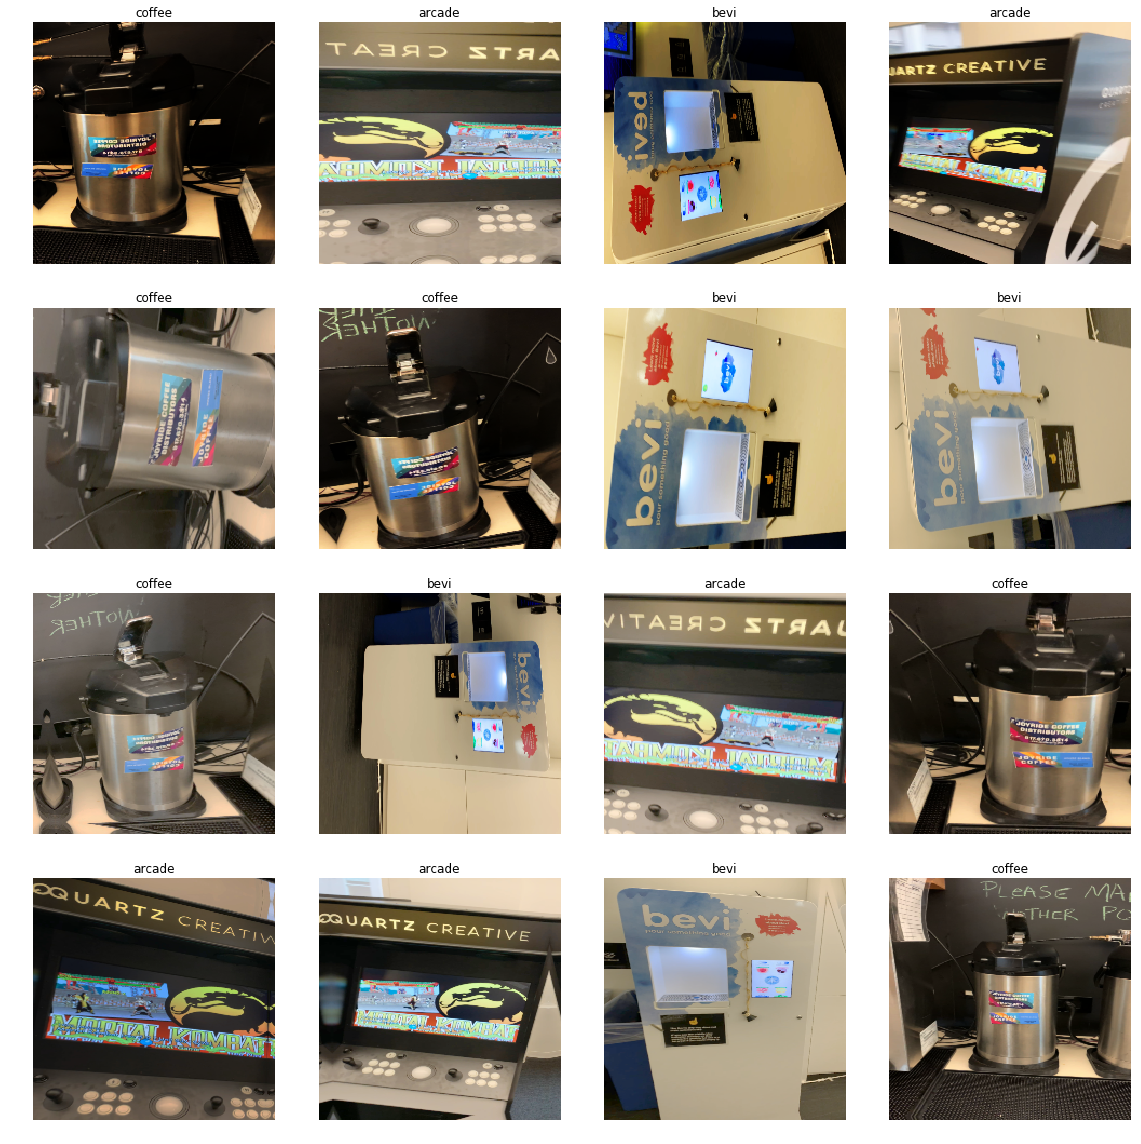

In [8]:
data.show_batch(rows=6)

In [9]:
print(data.classes)
len(data.classes),data.c

['arcade', 'bevi', 'coffee']


(3, 3)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.191473,0.000125,0.000000,02:32
1,0.060181,0.000116,0.000000,02:32
2,0.027191,0.000088,0.000000,02:29
3,0.016838,0.000069,0.000000,02:31


OK! So success rate of 100%

Which actually makes sense. These are three pretty distinct things in the world of objects.

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
interp.plot_top_losses(9)

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

At this point, the model is making no mistakes. It seems like there's no fine-tuning to do! I'll be curious to find out if it works in the real world. So moving to putting the model into production now.

In [16]:
learn.save('office-objects')

In [18]:
learn.load('office-objects');

Note that to save the entire package for inference later, we need to export this as a Pickle file, which will save `export.pkl` into the path.

In [19]:
learn.export()

## Doing this in production

This actually comes from the second lesson, in which Jeremy talks about putting these models into production. I'm using a service called [Render](https://render.com), which allows me to run the entire fastai library on a web service. Note that this costs $5/month.

In [20]:
data.classes

['arcade', 'bevi', 'coffee']

Production computers can use the model on a CPU -- without the need for a GPU. Also it's better that way. So here I tell the computer to use the CPU instead of the GPU

In [21]:
defaults.device = torch.device('cpu')  # for the gpu it would be 'cuda'

Now I grab a single image.

In [22]:
img = open_image('/home/ubuntu/data/office/coffee/coffee0103.jpg')

In [ ]:
img

In [55]:
# learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [24]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category coffee

Here's the whole prediction object, which is: category, category number, tensor with the predictions for each category

In [25]:
learn.predict(img)

(Category coffee, tensor(2), tensor([2.5780e-07, 3.9595e-06, 1.0000e+00]))

### Very wrong image
Let's try with an image that is definitely none of the above.



In [ ]:
img2 = open_image('/home/ubuntu/data/random/random20135.jpg')
img2

In [27]:
# This line loads the `export.pkl` file we saved above
inference = load_learner(path)

In [28]:
lets_predict = inference.predict(img2)
lets_predict

(Category coffee, tensor(2), tensor([0.1335, 0.1811, 0.6854]))

Remember, our classes are:

In [29]:
data.classes

['arcade', 'bevi', 'coffee']

So you can read the prediction tensor above as:

```
arcade: 0.1335
bevi: 0.1811
coffee: 0.6854
```

So the model thinks the fire extinguisher looks most like the coffee pot(!) but it's only 68.5% _confident_ it's a coffee pot. 

Here's how I'm setting the threshold for confidence at 85%:

In [30]:
# The category is the second value in the prediction object
# which we turn into a number with .item()
cat_number = lets_predict[1].item()
cat_number

2

It's zero-indexed, so 2 is the third item, `coffee`.

In [31]:
# The tensor with all of the confidence levels is the third value in the object
predictions = lets_predict[2]
predictions

tensor([0.1335, 0.1811, 0.6854])

In [32]:
# Here I pluck the cat_number'th value from the predictions tensor
# and make it a number with .item()
confidence = predictions[cat_number].item()
confidence

0.6854089498519897

In [33]:
float(confidence)

0.6854089498519897

## Preparing to use Render

Here we expert the model as `export.pkl` so we can make it available to [Render](https://render.com). 

In [34]:
# Check the path where it's going to go ...
print (learn.path)

/home/ubuntu/data/office


In [37]:
# Export the model there (if we haven't done it above)
learn.export()

In [35]:
# You'll also need these for Render:
data.classes

['arcade', 'bevi', 'coffee']

### Putitng the model on S3

Next, I need to put `export.pkl` somewhere that is public for Render to fetch it. There are instructions in the Render docs on [how to read a model from Dropbox or Google Drive](https://course.fast.ai/deployment_render.html), though I prefer to put it an Amazon S3 bucket (even tho that's actually trickier).

I have all of my AWS credentials on my laptop -- and don't want to take the time to set up those credentials on the EC2 instance where I do my fast.ai work. So I'm going to download my zip file to my local machine and work from there.

Here's what I ran on my local machine:

```
ssh-add [local path to MY EC2 SSH KEY]
cd Downloads
scp ubuntu@MY-EC2-IP-ADDRESS:data/office/export.pkl export.pkl
```

Then I uploaded the model to my S3 bucket with the AWS command-line tool (CLI), which I already have installed:

```
aws s3 cp export.pkl s3://qz-aistudio-public/office-objects/office-model.pkl --acl public-read
```

## My Render App

For running predictions in the wild, I'm using a fastai Python app that I upload to [Render](https://render.com). I signed up using my GitHub account, which makes things go really smoothly.

Here's the [repo for that app](https://github.com/jkeefe/render-fastai-office-objects), which is based on the [Render demo repo](https://github.com/render-examples/fastai-v3) -- with some nifty modifications by me.

Note that because this app uses a Docker instance, the Render tier you need is "Standard," which costs $5/month.

In the app, the main things to change are located in `apps/server.py` and are:

- The public url of the `.pkl` file
- The classes the model returns (from `classes.data`)

### Getting Render going

Once I signed up for Render, I added a "Web Service" -- and linked that to my [public app repo](https://github.com/jkeefe/render-fastai-office-objects). Whenever I update the `master` branch on that repo, the app redeploys, which is pretty cool.

Once that's running, I watch the "Events" tab to see if my code is being uploaded to Render correctly, and "Logs" tab to see if things are working when I try to use the app.

### Troubleshooting

So I sometimes get this error in the Render logs: `AttributeError: 'Conv2d' object has no attribute 'padding_mode'`, which I solved by making sure the PyTorch version I have here is the same as I have in the Render `requirements.txt`.

In [39]:
import torch
print(torch.__version__)

1.0.1.post2


Ack. That's not the current version.

Looks like `fastai`, `torch`, and `torchvision` have to match the EC2 instance where I use this notebook and the `requirements.txt` file I upload to Render. 

In the terminal on the EC2 instance, I used `pip list` to see the versions there.

Then I updated `requirements.txt` with the things I need, which should be along these lines ... 

```
torchvision==0.2.1
https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp37-cp37m-linux_x86_64.whl
fastai==1.0.51

fastai==1.0.52
https://download.pytorch.org/whl/cpu/torch-1.1.0-cp37-cp37m-linux_x86_64.whl
https://download.pytorch.org/whl/cpu/torchvision-0.3.0-cp37-cp37m-linux_x86_64.whl

```


## Experimenting with getting image from url


I wanted to process images not just from the form in the sample app, but also from URLs I send to the app through a POST request. 

What's nice is that since the Render app and this notebook are running the same versions of fastai and all the other packages, I can play here to figure out how best to code the Render app. So that's what I did below.

In [36]:
from io import BytesIO
import requests

In [37]:
url = 'https://qz-aistudio-public.s3.amazonaws.com/office-objects/coffee.png'

In [ ]:
# Ah! open_image is a fastai function
??open_image()

In [38]:
response = requests.get(url)
img3 = open_image(BytesIO(response.content))

In [ ]:
img3

In [40]:
lets_predict = inference.predict(img3)
lets_predict

(Category coffee, tensor(2), tensor([2.7351e-05, 4.2916e-06, 9.9997e-01]))

I incorporated this code into my render app, which essentially makes a new endpoint at `../checkurl` where I can post a URL and get a JSON response from the prediction.